### Ejercicios del tema de Clasificación

*Hugo Díaz Díaz* (*hdiazd00@estudiantes.unileon.es*)

*Correo profesional: hugo.didi.contacto@gmail.com*

---

## Parte teórica (opcional)

### 1. ¿Cuál es la profundidad aproximada de un Árbol de Decisión entrenado (sin restricciones) en un conjunto de entrenamiento con 1 millón de muestras?

Cuando un árbol de decisión se entrena sin ninguna limitación, sigue dividiendo mientras encuentre una reducción de impureza. Como en cada división las muestras se van partiendo en subconjuntos cada vez más pequeños, el árbol va profundizando nivel a nivel hasta que ya no quedan mejoras posibles.

Con un conjunto tan grande como uno de un millón de instancias, este proceso suele dar lugar a árboles profundos, con muchas decenas de niveles. Por tanto, la profundidad aproximada estará en ese orden: varias decenas de niveles.

### 2. La impureza Gini de un nodo, ¿es generalmente menor o mayor que la de su padre? ¿Es generalmente menor/mayor, o siempre menor/mayor?

Cada división intenta reducir la impureza respecto al nodo padre, así que lo normal es que los hijos tengan una impureza menor. Sin embargo, no es estrictamente obligatorio que sea siempre menor en ambos hijos: lo que sí garantiza el algoritmo es que la impureza ponderada de los dos hijos será menor que la del padre. Por tanto, generalmente es menor, pero no siempre en todos los nodos individuales.

### 3. Si un Árbol de Decisión está sobreajustando el conjunto de entrenamiento, ¿es una buena idea intentar disminuir `max_depth`?

Sí, totalmente. Reducir la profundidad máxima limita la complejidad del árbol y actúa como regularización, así que disminuir `max_depth` es una de las formas clásicas de combatir el *overfitting*.

### 4. Si un Árbol de Decisión se ajusta demasiado poco al conjunto de entrenamiento, ¿es una buena idea intentar escalar las características de entrada?

No, los árboles no dependen de la escala de los atributos, así que escalar no va a mejorar el ajuste. Si el modelo está infraajustando, lo adecuado sería relajar la regularización (permitir más profundidad, más hojas, etc.). 

### 5. Si se tarda una hora en entrenar un Árbol de Decisión en un conjunto de entrenamiento que contiene 1 millón de instancias, ¿cuánto tiempo se tardará aproximadamente en entrenar otro Árbol de Decisión en un conjunto de entrenamiento que contiene 10 millones de instancias?

El tiempo de entrenamiento de un árbol de decisión crece aproximadamente como $n \cdot \log n$, porque el árbol procesa todas las muestras y además su profundidad aumenta de forma logarítmica con el tamaño del dataset. Al pasar de 1 millón a 10 millones de instancias, el factor dominante es el salto lineal: multiplicas por diez la cantidad de datos. El término logarítmico también sube, pero muy poco (de unos 20 niveles a 23).

En conjunto, el tiempo final será aproximadamente diez veces mayor, así que si antes tardaba 1 hora, con 10 millones tardará alrededor de unas 10 horas.

### 6. Si su conjunto de entrenamiento contiene 100.000 instancias, ¿acelerará el entrenamiento si establece `presort=True`?

No. El preordenamiento solo es útil para datasets pequeños. A partir de unas decenas de miles de instancias, el coste del presort hace que en realidad vaya más lento. Con 100.000 muestras no aporta mejoras.

## Parte práctica (obligatoria)

### 1. Entrena y ajusta un Árbol de Decisión para el conjunto de datos Moons.

In [57]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# For reproducibility
np.random.seed(42) 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### a) Genera un conjunto de datos Moons utilizando make_moons(`n_samples=10000`, `noise=0.4`).

Lo primero es generar el dataset sintético tipo “moons” con bastante ruido para que el problema no sea trivial. 

In [58]:
from sklearn.datasets import make_moons

# Genero el conjunto de datos Moons con 10.000 muestras y ruido 0.4
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

print(X.shape, y.shape)

(10000, 2) (10000,)


Esto representan 10.000 puntos bidimensionales y sus etiquetas binarias correspondientes.

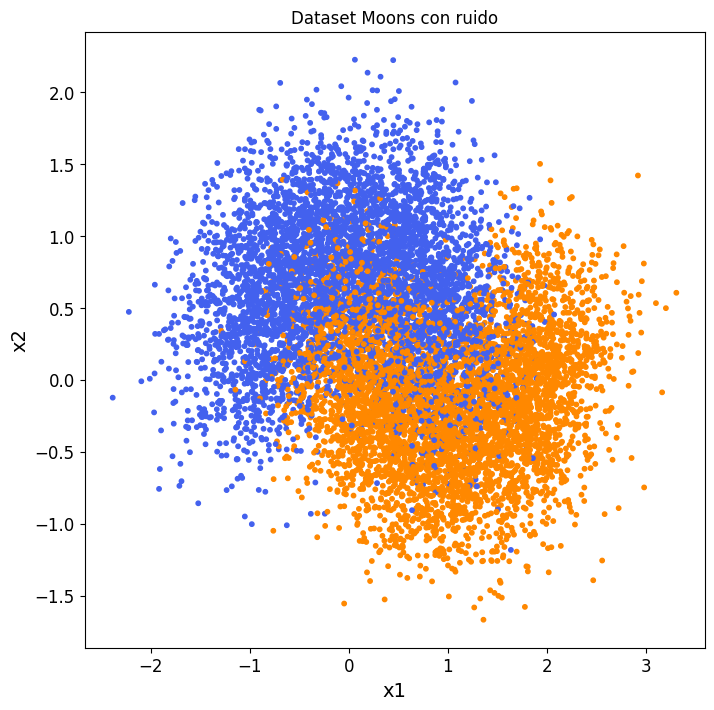

In [59]:
# Representar los datos generados

plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(["#4361ee", "#ff8800"]), s=10, alpha=1)
plt.title("Dataset Moons con ruido")      
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

#### b) Divídelo en un conjunto de entrenamiento y un conjunto de test usando `train_test_split()`.

Ahora divido los datos en train y test. Uso un 80/20 típico y fijo también `random_state` para que la partición sea estable. Aprovecho para estratificar según la clase y mantener proporciones similares en ambos conjuntos.

In [60]:
from sklearn.model_selection import train_test_split

# Divido en entrenamiento y test, 80% / 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(8000, 2) (2000, 2)


Con esto ya está listo el entorno básico: datos generados y partición hecha.

#### c) Utiliza `GridSearchCV` para encontrar buenos valores de hiperparámetros para un `DecisionTreeClassifier`. Sugerencia: pruebe varios valores para `max_leaf_nodes`.

Ahora se define un árbol de decisión de clasificación y se realiza una búsqueda en rejilla para encontrar buenos hiperparámetros. En los apuntes se insiste bastante en jugar con parámetros como `max_leaf_nodes` y los hiperparámetros de regularización, así que la búsqueda se centra en eso.
La idea es explorar distintos números máximos de hojas y complementar con algo de control usando `min_samples_split`.

Recordemos que un número menor de hojas implica un árbol más simple y menos propenso a sobreajustar, mientras que un número mayor permite capturar más complejidad. Igualmente, `min_samples_split` controla cuántas muestras mínimas debe tener un nodo para dividirse, lo que también afecta la complejidad del árbol.

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Defino el clasificador base
tree_clf = DecisionTreeClassifier(random_state=42)

# Defino la rejilla de hiperparámetros a explorar
param_grid = {
    "max_leaf_nodes": [None, 10, 20, 30, 40, 50, 60],
    "min_samples_split": [2, 4, 6, 8, 10]
}

# Configuro GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=tree_clf,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

# Ajusto la rejilla sobre el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor accuracy (cv):", grid_search.best_score_)


Mejores hiperparámetros: {'max_leaf_nodes': 20, 'min_samples_split': 2}
Mejor accuracy (cv): 0.8581246830267747


Esto quiere decir que, para este dataset con bastante ruido, un árbol con alrededor de 20 hojas maximiza el equilibrio entre flexibilidad y capacidad de generalización. No es sorprendente que `min_samples_split = 2` funcione bien aquí, porque el ruido hace que el árbol tienda a explorar algo más fino en los primeros niveles.

#### d) Entrénalo con el conjunto de entrenamiento completo utilizando estos hiperparámetros y mide el rendimiento de su modelo en el conjunto de pruebas. Debería obtener entre un 85% y un 87% de exactitud.

Una vez seleccionados los hiperparámetros óptimos, se entrena un árbol de decisión final utilizando toda la información disponible en el conjunto de entrenamiento. Este paso permite aprovechar completamente el dataset manteniendo la regularización establecida por la limitación de hojas.

In [62]:
from sklearn.metrics import accuracy_score

best_params = grid_search.best_params_

final_tree_clf = DecisionTreeClassifier(
    **best_params,
    random_state=42
)

final_tree_clf.fit(X_train, y_train)

y_test_pred = final_tree_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Accuracy en test:", test_accuracy)


Accuracy en test: 0.853


La evaluación en el conjunto de prueba muestra una exactitud acorde con lo esperado para este ejercicio (85.3%), lo que indica que el modelo generaliza de forma adecuada pese al nivel de ruido presente en los datos. Podemos graficar la frontera de decisión para visualizar cómo el árbol ha aprendido a separar las dos clases en el espacio bidimensional.

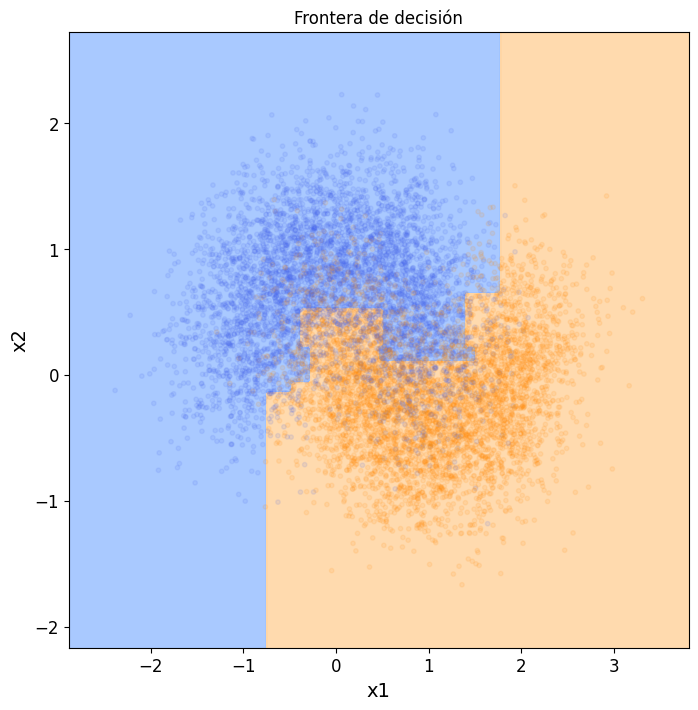

In [63]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y):
    # Crear la malla 2D
    x1s = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 200)
    x2s = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 200)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    # Predecir en cada punto de la rejilla
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.figure(figsize=(8,8))
    # Dibujar el fondo coloreado según la predicción
    plt.contourf(x1, x2, y_pred, alpha=0.9, cmap=ListedColormap(["#a0c4ff", "#ffd6a5"]))

    # Dibujar los puntos reales con mayor transparencia
    plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(["#4361ee", "#ff8800"]), s=10, alpha=0.1)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Frontera de decisión")
    plt.show()
plot_decision_boundary(final_tree_clf, X, y)

Una vez agotadas las mejoras posibles con un único árbol optimizado mediante GridSearchCV, los apuntes indican que la forma más eficaz de aumentar el *accuracy* es pasar a un método en ensamble, concretamente a un Random Forest. Los árboles de decisión son modelos muy inestables, y esta inestabilidad se convierte en ventaja cuando se combinan muchos de ellos: al entrenar múltiples árboles sobre subconjuntos distintos y tomar la predicción mayoritaria, los errores individuales se compensan y la frontera de decisión se vuelve más estable y precisa. En el propio tema se demuestra que esta técnica mejora ligeramente el rendimiento respecto al mejor árbol individual, y por eso sería la vía recomendada para obtener un accuracy superior en este problema.

### 2. Cultivar un bosque.

#### a) Continuando con el ejercicio anterior, genere 1.000 subconjuntos del conjunto de entrenamiento, cada uno con 100 muestras seleccionadas aleatoriamente. Sugerencia: para ello puedes utilizar la clase `ShuffleSplit` de Scikit-Learn.

#### b) Entrena un Árbol de Decisión en cada subconjunto, utilizando los mejores valores de hiperparámetros encontrados anteriormente. Evalúe estos 1.000 árboles de decisión en el conjunto de test. Dado que fueron entrenados en conjuntos más pequeños, estos Árboles de Decisión probablemente funcionarán peor que el primer Árbol de Decisión, alcanzando sólo un 80% de exactitud.

#### c) Para cada muestra, genera las predicciones de los 1.000 árboles de decisión y conserva sólo la predicción más frecuente (puedes usar la función `mode()` de SciPy). Así obtendrás predicciones mayoritarias sobre el conjunto de prueba.

#### d) Evalúa estas predicciones en el conjunto de test: deberías obtener una exactitud ligeramente superior a la de tu primer modelo (entre un 0,5 y un 1,5% más). Enhorabuena, has entrenado un clasificador Random Forest.